# Задача
### Прогноз цен на квартиры

1. Предобработка данных
    - проверка пропусков
    - визуализация данных (hist, heatmap, pairplot)
    - работа с категориальными переменными
    - скалирование данных
2. Константный прогноз
3. Метрики качества для регрессии
    - MAE
    - MSE
    - RMSE
    - MAPE
    - R2
4. Регрессия
    - Lasso Regression 
    - GridSearchCV - подбор гиперпараметров
    - LassoCV
    - Feature importance

# 1. Предобработка данных 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd               
import numpy as np               
import matplotlib.pyplot as plt   
import seaborn as sns              

%matplotlib inline

In [4]:
df = pd.read_csv('flat.csv', sep='\t', index_col='n')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (2040, 10)


,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


__Описание переменных:__

```
n – номер квартиры по порядку
price – цена квартиры в $1000
totsp – общая площадь квартиры, кв.м.
livesp жилая площадь квартиры, кв.м.
kitsp – площадь кухни, кв.м.
dist – расстояние от центра в км.
metrdist – расстояние до метро в минутах
walk – 1 – пешком от метро, 0 – на транспорте
brick 1 – кирпичный, монолит ж/б, 0 – другой
floor 1 – этаж кроме первого и последнего, 0 – иначе.
code – число от 1 до 8, при помощи которого мы группируем наблюдения по
подвыборкам:
1. Наблюдения сгруппированы на севере, вокруг Калужско-Рижской линии
метрополитена
2. Север, вокруг Серпуховско-Тимирязевской линии метрополитена
3. Северо-запад, вокруг Замоскворецкой линии метрополитена
4. Северо-запад, вокруг Таганско-Краснопресненской линии метрополитена
5. Юго-восток, вокруг Люблинской линии метрополитена
6. Юго-восток, вокруг Таганско-Краснопресненской линии метрополитена
7. Восток, вокруг Калиниской линии метрополитена
8. Восток, вокруг Арбатско-Покровской линии метрополитена
```

In [6]:
df.info() 
# Расмотрим на информацию по типам переменных 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


In [8]:
df.isnull().sum()  # посмотрим на то есть ли в переменных пропуски

price       0
totsp       0
livesp      0
kitsp       0
dist        0
metrdist    0
walk        0
brick       0
floor       0
code        0
dtype: int64

В этом датасете нет пропусков.

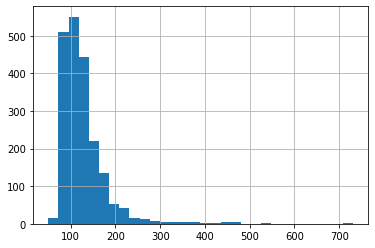

In [9]:
df.price.hist(bins=30); # расмотрим как выглядит распределение цен (целевая переменная)

У распределения цен есть проблема - очень длинный хвост. В выборке встречаются квартиры с довольно большой стоимостью. Это значит у нас есть выбросы. С ними нужно бороться, иначе наша модель подстроится под них. Давайте сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной. 

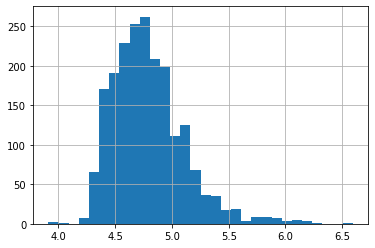

In [10]:
df['price'] = np.log(df['price'])
df.price.hist(bins=30);

Теперь наша целевая переменная более похожа на нормальное распеределение.

Посмотрим на распределение всех остальных признаков. 

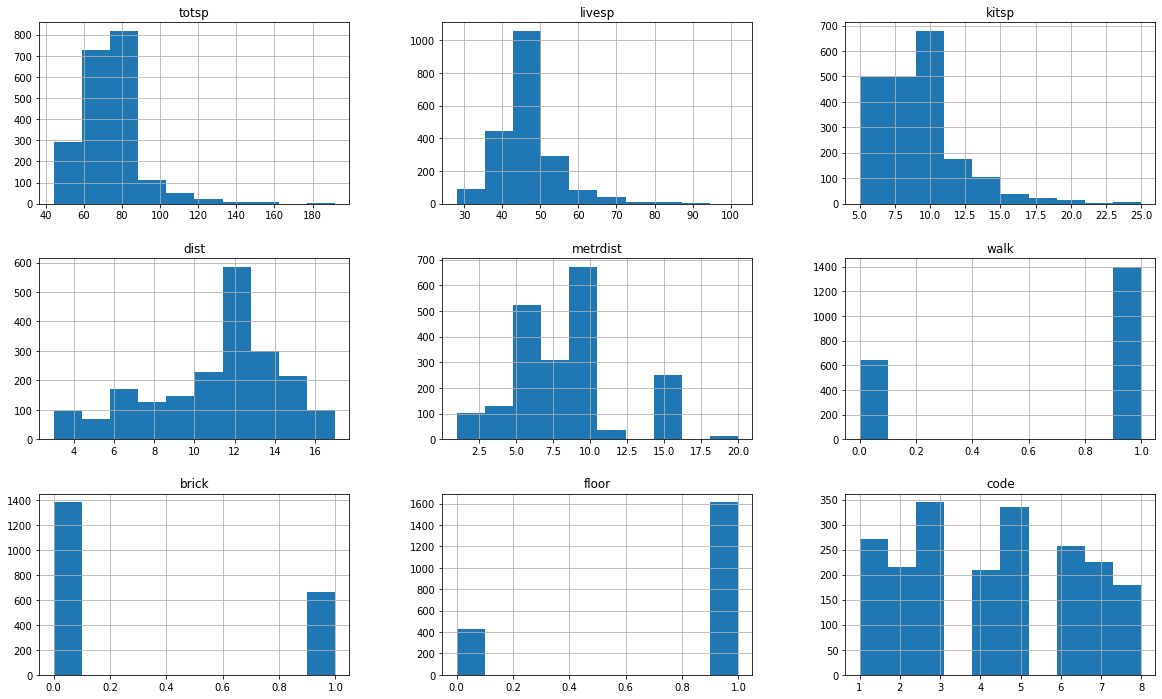

In [11]:
df.drop('price',axis=1).hist(figsize=(20, 12));

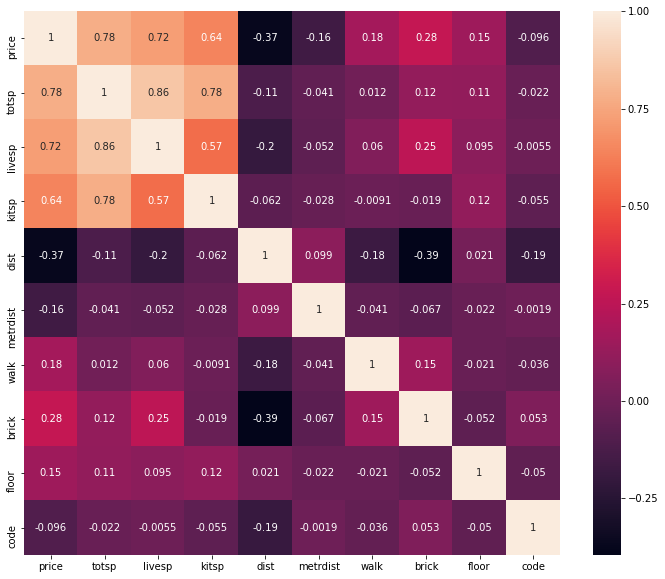

In [13]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True); # рассмотрим матрицу корреляции

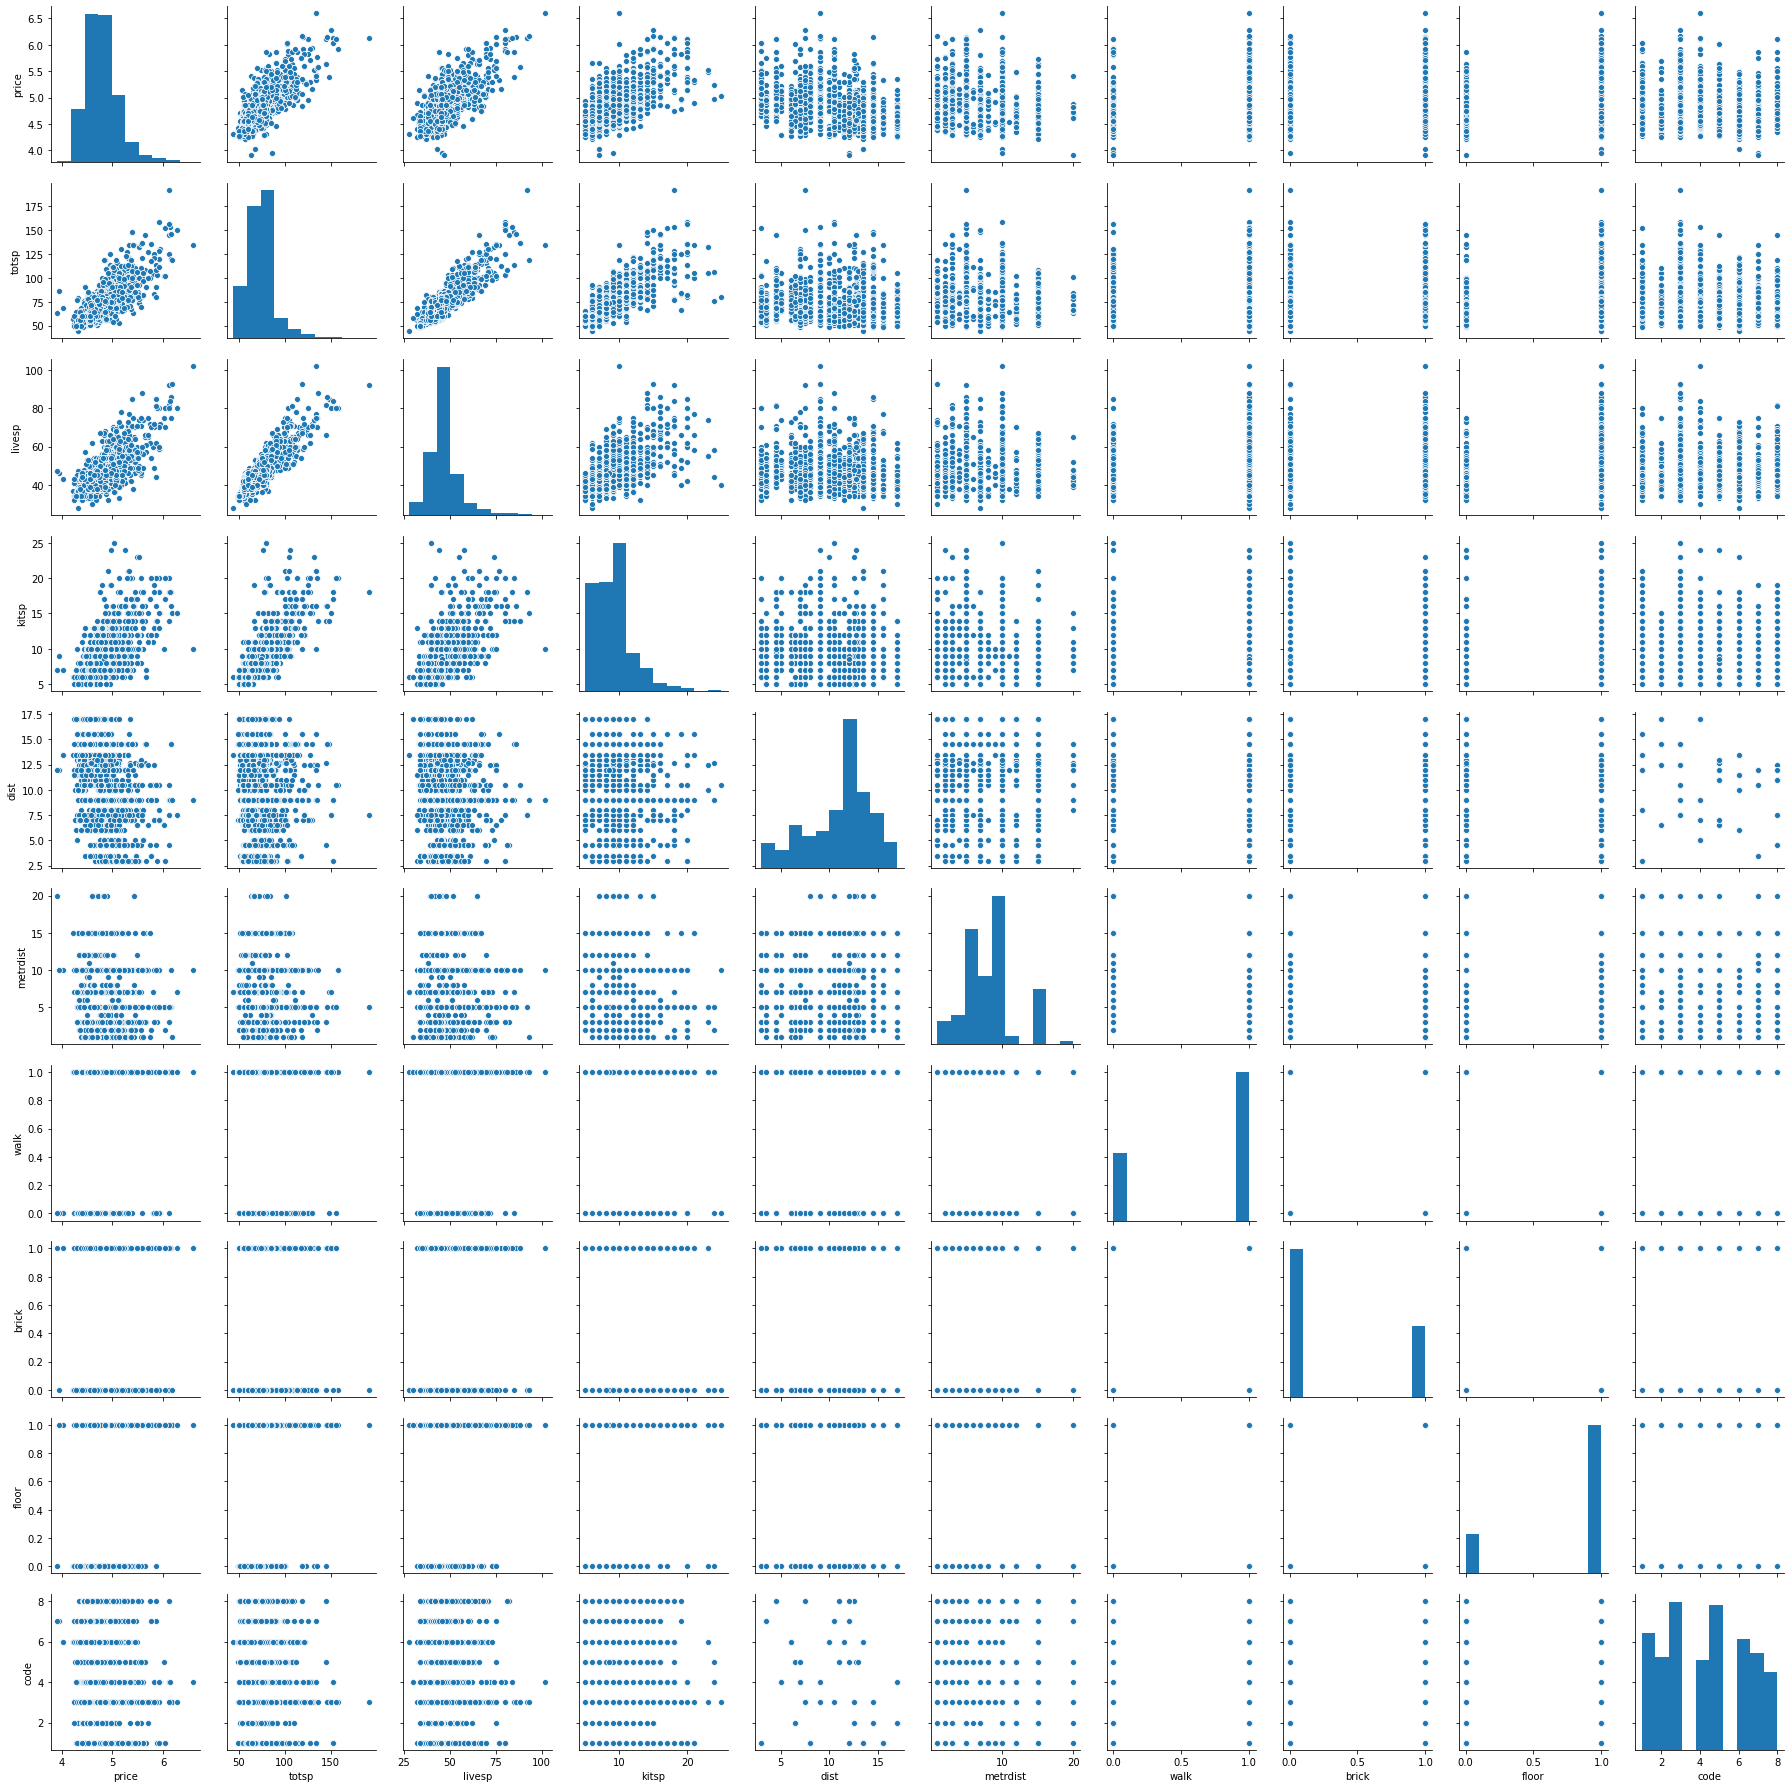

In [14]:
sns.pairplot(df) # рассмотрим облака рассеивания

Видна линейная зависимость между целевой переменной (цена) и (общей площадью квартиры и жилой площадью квартиры). Также общая площадь квартиры линейно зависима от жилой площади квартиры. 

### Категориальные переменные 

Займёмся предобработкой категориальных переменных при помощи One Hot Encoding.

In [15]:
# Сделали OHE для категориальной переменной
df_categor = pd.get_dummies(df['code'], drop_first=True, prefix='code')

# Объединили назад наши таблички
df = pd.concat([df.drop('code',axis=1),df_categor], axis=1)
df.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
1,4.394449,58,40,6.0,12.5,7,1,1,1,0,1,0,0,0,0,0
2,4.317488,44,28,6.0,13.5,7,1,0,1,0,0,0,0,1,0,0
3,4.852030,70,42,6.0,14.5,3,1,1,1,0,1,0,0,0,0,0
4,4.553877,61,37,6.0,13.5,7,1,0,1,0,0,0,0,0,0,0
5,5.799093,104,60,11.0,10.5,7,0,1,1,0,1,0,0,0,0,0


Делим данные на тренировочные и тестовые! $30\%$ данных откладываем для тестирования качества модели. Остальные $70\%$ берём для обучения. 

In [16]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

### Скалирование данных 

Последний предобрабатывательский штрих это скалирование (стандартизация непрерывных переменных).

In [17]:
from sklearn.preprocessing import StandardScaler

# объявили скалировщик!
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

In [19]:
# Заменяем значения на отскалированные
df_train[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_train_scale
df_test[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = df_test_scale

In [21]:
df_train.head() # Все непрерывные переменные теперь выглядят проскалированными

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_2,code_3,code_4,code_5,code_6,code_7,code_8
n,,,,,,,,,,,,,,,,
1634,5.099866,-0.051885,0.218353,-0.655408,-2.270543,-0.823761,1,1,1,0,0,0,0,0,1,0
1556,5.087596,0.864437,1.453728,0.054027,0.270378,-0.048158,1,1,1,0,0,0,0,0,0,1
1656,4.753590,0.275373,-0.152259,3.246487,-1.523213,-0.306693,0,0,1,0,0,0,0,1,0,0
609,4.700480,-0.510045,-0.152259,0.763463,-1.224281,-0.306693,1,0,1,0,0,1,0,0,0,0
778,4.564348,-0.837303,-0.152259,-1.010126,1.316640,-0.823761,1,0,1,0,0,0,0,0,0,0


In [22]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape) 

(1428, 16)
(612, 16)


In [25]:
# Вытаскиваем цены и параметры квартир по разным переменным для удобства 

y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

# 2. Константный прогноз

Шаг первый. Построим константный прогноз. Будем говорить, что стоимость любой квартиры равна среднему значению. Это самый глупый прогноз, который мы можем сделать. Мы будем сравнивать с ним прогнозы более сложных моделей. 

In [27]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им цену всех квартир в тестовой выборке
y_pred_naive[:5]

array([4.7856201, 4.7856201, 4.7856201, 4.7856201, 4.7856201])

# 3. Метрики качества для регрессии 

Мы сделали выше прогноз. Теперь мы хотим понять насколько он хороший. Для этого обычно используют метрики. Посмотрим на несколько таких метрик. 

In [29]:
from sklearn import metrics  # подгружаем метрики

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Мы прогнозируем логарифм цены, нам так удобнее. Ошибка считается в логарифмах. Если мы хотим посмотреть на ошибку в долларах, надо взять экспоненту от цен.

In [31]:
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [32]:
print_metrics(y_test, y_pred_naive)

MAE: 30.460218427052396
RMSE: 46.07306482892509
R2: -0.00409004762787446
MAPE: 4.781781793826713


# 4. Строим регрессию

In [33]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на качество прогнозов. Мы стали ошибаться меньше, чем раньше. 

In [34]:
print_metrics(y_test,y_pred_regr)

MAE: 15.441047159283258
RMSE: 26.878665682468046
R2: 0.758623603129625
MAPE: 2.229833092004009


Посмотрим на то, какие признаки вносят в цену наибольший вклад. 

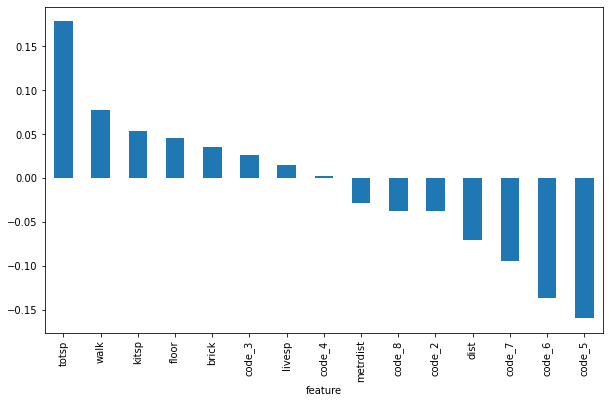

In [36]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

Чем больше площадь жилой квартиры (totsp), пешком до метро (walk), больше площадь кухни (kitsp), выше этаж (floor), меньше растояние до центра (dist), тем больше цена квартир.

# 4. Строим Lasso-регрессию 


Построим более сложную модель, LASSO-регрейссию. Фишка этой модели в том, что она зануляет лишние коэффиценты. 

In [37]:
from sklearn.linear_model import Lasso

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

Посмотрим на важность факторов для стоимости квартиры. 

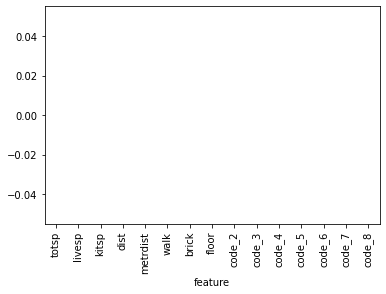

In [39]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_simplelasso.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

In [40]:
print_metrics(y_test,y_pred_lasso)

MAE: 30.4602184270524
RMSE: 46.07306482892508
R2: -0.004090047627874238
MAPE: 4.781781793826715


# 5. Подбор гиперпараметра для Lasso-регрессии

Будем делать перебор следующим способом: дробим тренировочную выборку на пять частей. На четырёх учим модель, на пятой прогнозируем. Смотрим на качество. И так по очереди выделяем для прогноза каждую из 5 частичек. Потом качество прогноза усредняем - кросс-валидация. Для какого параметра из решётки качетство получится наибольшим, тот мы и оставим. 

In [41]:
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}


При параметре 0.001 качество у прогнозов получилось самым хорошим. Его и берём. Посмотрим на важность переменных

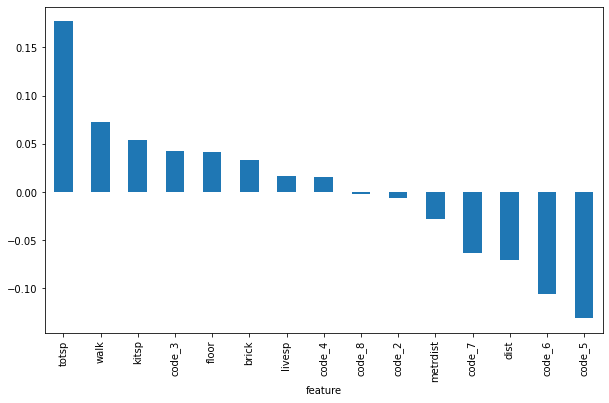

In [43]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [44]:
print_metrics(y_test,y_pred_lasso)

MAE: 15.474961914045133
RMSE: 26.815294698295563
R2: 0.7586949479595027
MAPE: 2.2343030424234582


Качество модели оказывается близким к обычной регрессии. Судя по всему у нас в выборке нет лишних переменных и занулять нечего.

In [45]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

# Сделали прогнозы
y_pred_lasso_cv = lasso_cv.predict(X_test)

Лучшее значение параметра: 0.0002530898812666185


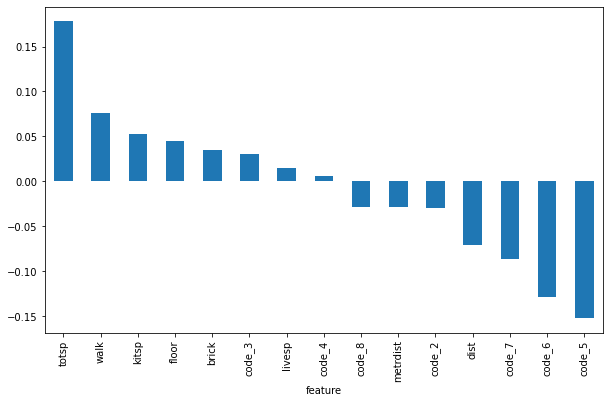

In [47]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": lasso_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(10, 6));

In [48]:
print_metrics(y_test, y_pred_lasso_cv)

MAE: 15.440078227572865
RMSE: 26.855846688819902
R2: 0.7589496634999674
MAPE: 2.229154969522517
